In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

# define a few constants
pi = np.pi

MSME = 332948.6                            # (M_sun/M_earth)

RNRE = 3.8647      # (Rnep/Rearth)
RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)

RSRN = RSRE/RNRE   # (Rsun/Rnep)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

BIGG = 6.67e-11    # Newton's constant [SI units]

RSUN = 6.957e8     # solar radius [m]
MSUN = 1.988e30    # Solar mass [kg]

GSUN = BIGG / RSUN**3 * MSUN * (24*3600)**2    # Newton's constant [R_sun^3 * M_sun^-1 * days^-2]

# define a few colors
robinseggblue = '#bfe2ff'
royalpurple = '#9e00a3'
lavender = '#cc98d9'

# Read in CKS data

In [2]:
# READ IN CKS DATABASE
# documentation of csv file found at http://www.astro.caltech.edu/~howard/cks/column-definitions.txt

cks_file = '/Users/research/Desktop/dinosaur/clean_maiasaurus_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

In [3]:
# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = getkey('id_starname')             # star id - 'K00082'
d['koi']         = getkey('id_koicand')
d['kic']         = getkey('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = getkey('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = getkey('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = getkey('koi_model_snr')           # transit signal-to-noise
d['npl']         = getkey('koi_count')               # number of planets in system

d['period']      = getkey('koi_period')              # period (days)
d['period_err1'] = getkey('koi_period_err1')
d['period_err2'] = getkey('koi_period_err2')

d['rprs']      = getkey('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = getkey('koi_ror_err1')
d['rprs_err2'] = getkey('koi_ror_err2')

d['impact']      = getkey('koi_impact')              # impact parameter
d['impact_err1'] = getkey('koi_impact_err1')
d['impact_err2'] = getkey('koi_impact_err2')

d['koi_duration']      = getkey('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = getkey('koi_duration_err1')
d['koi_duration_err2'] = getkey('koi_duration_err2')

d['rp']      = getkey('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = getkey('iso_prad_err1')
d['rp_err2'] = getkey('iso_prad_err2')

d['sma']      = getkey('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = getkey('iso_sma_err1')
d['sma_err2'] = getkey('iso_sma_err2')

d['rstar']      = getkey('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = getkey('iso_srad_err1')
d['rstar_err2'] = getkey('iso_srad_err2')

d['mstar']      = getkey('iso_smass')                # CKS+isochrone constrained stellar mas (solar mass)
d['mstar_err1'] = getkey('iso_smass_err1')
d['mstar_err2'] = getkey('iso_smass_err2')

d0 = d.copy()

In [4]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

total number of queried objects = 864
after removing missing data, number of objects = 864


In [5]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

# Read in masses from Andrew

In [6]:
d['mp'] = np.load('/Users/research/Desktop/dinosaur/catalogues_from_andrew/cks_pred_masses_oct9.npy')

# Calculate compexity metrics for each system

In [7]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [8]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    # pull planetary data
    s.rprs    = d['rprs'][d['starname']==us]
    s.masses  = d['mp'][d['starname']==us]
    s.periods = d['period'][d['starname']==us]

    # pull transit durations and errors, convert hrs to days
    s.dur     = d['koi_duration'][d['starname']==s.sysid]/24
    s.dur_err = 0.5*((d['koi_duration_err1'][d['starname']==s.sysid]) -
                     (d['koi_duration_err2'][d['starname']==s.sysid]))/24
    
    # sort masses, periods, and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.masses  = s.masses[order]
    s.periods = s.periods[order]
    s.dur     = s.dur[order]
    s.dur_err = s.dur_err[order]
    
    
    # calculate complexity measures (N, mu, Q, M, S, C, f)
    s.N  = len(s.masses)
    s.mu = archinfo.mu(s.masses, s.Mstar)
    s.Q  = archinfo.Q(s.masses)
    s.M  = archinfo.M(s.periods, s.masses)
    s.S  = archinfo.S(s.periods, s.masses, s.Mstar)
    s.C  = archinfo.C(s.periods)
    s.f  = archinfo.f(s.periods, s.Mstar/s.Rstar**3, s.rprs, s.dur, s.dur_err)
      
    systems.append(s)

/Users/research/Desktop/dinosaur/maiasaurus/archinfo.py:48: RuntimeWarning: invalid value encountered in sqrt
  term2  = (term2a - term2b*term2c)**(1/2)
/Users/research/Desktop/dinosaur/maiasaurus/archinfo.py:142: UserWarning: Complexity is undefined for N < 3; returning NaN
  warnings.warn('Complexity is undefined for N < 3; returning NaN')


In [9]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
f  = np.zeros(Nsys)

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    f[i]  = s.f

logmu = np.log10(mu)

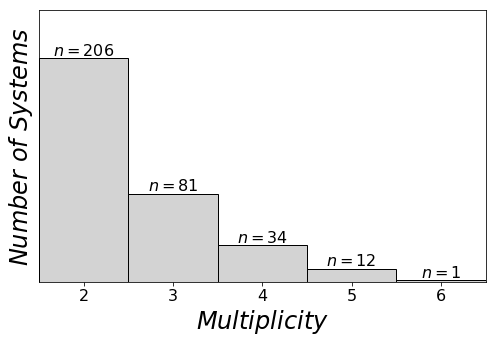

412 objects in  206  2-planet systems
243 objects in  81  3-planet systems
136 objects in  34  4-planet systems
60 objects in  12  5-planet systems
6 objects in  1  6-planet systems
7 objects in  1  7-planet systems
0 objects in  0  8-planet systems


In [10]:
plt.figure(figsize=(8,5))
plt.hist(N, bins=np.arange(2,8), color='lightgrey', edgecolor='k')
for i in range(2,7):
    plt.text(i+0.5, np.sum(N==i), r'$n = %d$' %np.sum(N==i), va='bottom', ha='center', fontsize=16)
plt.xticks([2.5,3.5,4.5,5.5,6.5,7.5],[2,3,4,5,6,7], fontsize=16)
plt.xlim(2,7)
plt.xlabel(r'$Multiplicity$', fontsize=24)
plt.ylim(0,250)
plt.yticks([])
plt.ylabel(r'$Number\ of\ Systems$', fontsize=24)
#plt.savefig('/Users/research/Desktop/multiplicity.png', bbox_inches='tight')
plt.show()

for i in range(2,9):
    print('%d objects in  %d  %d-planet systems' %(i*np.sum(N==i), np.sum(N==i), i))

# Results for $\mu$, $\mathcal{Q}$, & $\mathcal{M}$ 

In [11]:
# compare mu for 3 and 4+ planet systems
logmu2 = logmu[N==2]
logmu3 = logmu[N==3]
logmu4 = logmu[N>=4]

logmu2 = np.sort(np.squeeze(logmu2))
logmu3 = np.sort(np.squeeze(logmu3))
logmu4 = np.sort(np.squeeze(logmu4))

KS_mu43  = np.array(stats.ks_2samp(logmu4,logmu3))
KS_mu32  = np.array(stats.ks_2samp(logmu3,logmu2))

AD_mu43 = stats.anderson_ksamp([logmu4,logmu3])[2]
AD_mu32 = stats.anderson_ksamp([logmu3,logmu2])[2]

mu4mu3 = np.median(10**logmu4)/np.median(10**logmu3)
mu3mu2 = np.median(10**logmu3)/np.median(10**logmu2)


# compare Q for 3 and 4+ planet systems
Q2 = Q[N==2]
Q3 = Q[N==3]
Q4 = Q[N>=4]

Q2 = np.sort(np.squeeze(Q2))
Q3 = np.sort(np.squeeze(Q3))
Q4 = np.sort(np.squeeze(Q4))

KS_Q32 = np.array(stats.ks_2samp(Q3,Q2))
KS_Q43 = np.array(stats.ks_2samp(Q4,Q3))

AD_Q32 = stats.anderson_ksamp([Q3,Q2])[2]
AD_Q43 = stats.anderson_ksamp([Q4,Q3])[2]

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: p-value capped: true value larger than 0.25
  
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: p-value floored: true value smaller than 0.001


In [12]:
# compare mu over N
mu_over_N = []

for i, s in enumerate(systems):
    mu_over_N.append(s.mu/s.N)

mu_over_N = np.array(mu_over_N)
    

logmu_over_N_2 = np.log10(mu_over_N[N==2])
logmu_over_N_3 = np.log10(mu_over_N[N==3])
logmu_over_N_4 = np.log10(mu_over_N[N>=4])

logmu_over_N_2 = np.sort(np.squeeze(logmu_over_N_2))
logmu_over_N_3 = np.sort(np.squeeze(logmu_over_N_3))
logmu_over_N_4 = np.sort(np.squeeze(logmu_over_N_4))

KS_mu_over_N_43  = np.array(stats.ks_2samp(logmu_over_N_4,logmu_over_N_3))
KS_mu_over_N_32  = np.array(stats.ks_2samp(logmu_over_N_3,logmu_over_N_2))


AD_mu_over_N_43 = stats.anderson_ksamp([logmu_over_N_4,logmu_over_N_3])[2]
AD_mu_over_N_32 = stats.anderson_ksamp([logmu_over_N_3,logmu_over_N_2])[2]

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: p-value capped: true value larger than 0.25
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: p-value capped: true value larger than 0.25


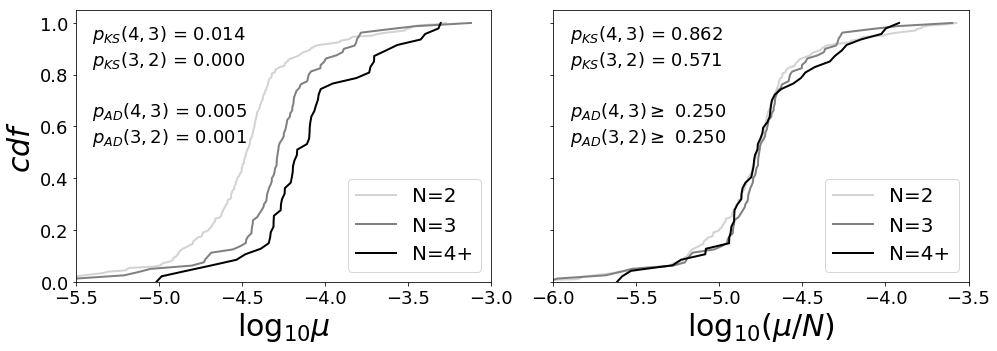

In [15]:
# plot mu
fig, axes = plt.subplots(1, 2, figsize=(16,5))

plt.subplots_adjust(wspace=0.15)

ax = axes[0]
ax.plot(logmu2, np.linspace(0,1,len(logmu2)), lw=2, color='lightgrey', label='N=2')
ax.plot(logmu3, np.linspace(0,1,len(logmu3)), lw=2, color='grey', label='N=3')
ax.plot(logmu4, np.linspace(0,1,len(logmu4)), lw=2, color='black', label='N=4+')
ax.set_xlim(-5.5,-3.0)
ax.set_xlabel(r'$\log_{10}\mu}$', fontsize=30)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=30)
ax.tick_params(labelsize=18)

ax.text(-5.4,1.0, r'$p_{KS}(4,3)$ = %.3f' %KS_mu43[1], fontsize=18, ha='left', va='top')
ax.text(-5.4,0.9, r'$p_{KS}(3,2)$ = %.3f' %KS_mu32[1], fontsize=18, ha='left', va='top')
ax.text(-5.4,0.7, r'$p_{AD}(4,3)$ = %.3f' %AD_mu43, fontsize=18, ha='left', va='top')
ax.text(-5.4,0.6, r'$p_{AD}(3,2)$ = %.3f' %AD_mu32, fontsize=18, ha='left', va='top')
ax.legend(loc='lower right', fontsize=20)



# plot mu_over_N
ax = axes[1]

ax.plot(logmu_over_N_2, np.linspace(0,1,len(logmu_over_N_2)), lw=2, color='lightgrey', label='N=2')
ax.plot(logmu_over_N_3, np.linspace(0,1,len(logmu_over_N_3)), lw=2, color='grey', label='N=3')
ax.plot(logmu_over_N_4, np.linspace(0,1,len(logmu_over_N_4)), lw=2, color='black', label='N=4+')
ax.set_xlim(-6.0,-3.5)
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=30)
ax.set_ylim(0,1.05)
ax.set_yticklabels([])
ax.tick_params(labelsize=18)

ax.text(-5.9,1.0, r'$p_{KS}(4,3)$ = %.3f' %KS_mu_over_N_43[1], fontsize=18, ha='left', va='top')
ax.text(-5.9,0.9, r'$p_{KS}(3,2)$ = %.3f' %KS_mu_over_N_32[1], fontsize=18, ha='left', va='top')
ax.text(-5.9,0.7, r'$p_{AD}(4,3) \geq$ %.3f' %AD_mu_over_N_43, fontsize=18, ha='left', va='top')
ax.text(-5.9,0.6, r'$p_{AD}(3,2) \geq$ %.3f' %AD_mu_over_N_32, fontsize=18, ha='left', va='top')
ax.legend(loc='lower right', fontsize=20)


plt.savefig('/Users/research/Desktop/Figures/mu_cdf.eps', bbox_inches='tight')

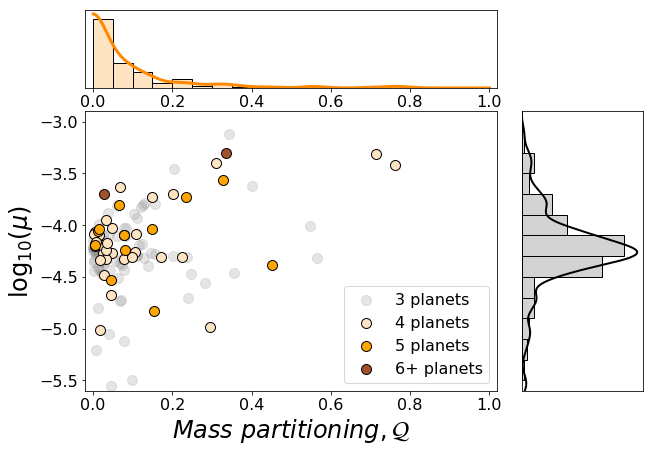

In [13]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Q[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
ax1.scatter(Q[N==5], logmu[N==5], c='orange', edgecolor='k', s=100, label='5 planets')
ax1.scatter(Q[N>=6], logmu[N>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# Q historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q[N>2],Q[N>2]])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(Q[N>2], bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
ax1h.plot(x[500:],y[500:]*2, c='#ff8800', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-2.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu[N>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu[N>2],bins=np.arange(-5.5,-2.75,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_ylim(-5.6,-2.9)
axsh.set_xticks([])
ax1h.tick_params(labelsize=16)

plt.savefig('/Users/research/Desktop/Figures/masspartitioning.pdf',bbox_inches='tight')
plt.show()

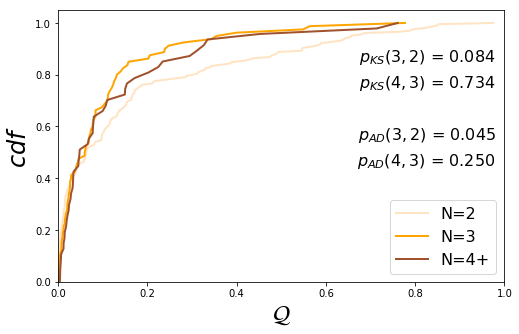

In [14]:
# plot Q
fig, ax = plt.subplots(1, figsize=(8,5))

ax.plot(Q2, np.linspace(0,1,len(Q2)), lw=2, color='bisque', label='N=2')
ax.plot(Q3, np.linspace(0,1,len(Q3)), lw=2, color='orange', label='N=3')
ax.plot(Q4, np.linspace(0,1,len(Q4)), lw=2, color='sienna', label='N=4+')
ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.text(0.98,0.85, r'$p_{KS}(3,2)$ = %.3f' %KS_Q32[1], fontsize=16, ha='right')
ax.text(0.98,0.75, r'$p_{KS}(4,3)$ = %.3f' %KS_Q43[1], fontsize=16, ha='right')
ax.text(0.98,0.55, r'$p_{AD}(3,2)$ = %.3f' %AD_Q32, fontsize=16, ha='right')
ax.text(0.98,0.45, r'$p_{AD}(4,3)$ = %.3f' %AD_Q43, fontsize=16, ha='right')
ax.legend(loc='lower right', fontsize=16)

#plt.savefig('/Users/research/Desktop/Figures/Q_cdf.pdf')
plt.show()

In [22]:
M3 = M[N==3]
M2 = M[N==2]
M4 = M[N>=4]

M2 = np.sort(np.squeeze(M2))
M3 = np.sort(np.squeeze(M3))
M4 = np.sort(np.squeeze(M4))


KS_M32 = np.array(stats.ks_2samp(M3,M2))
KS_M43 = np.array(stats.ks_2samp(M4,M3))


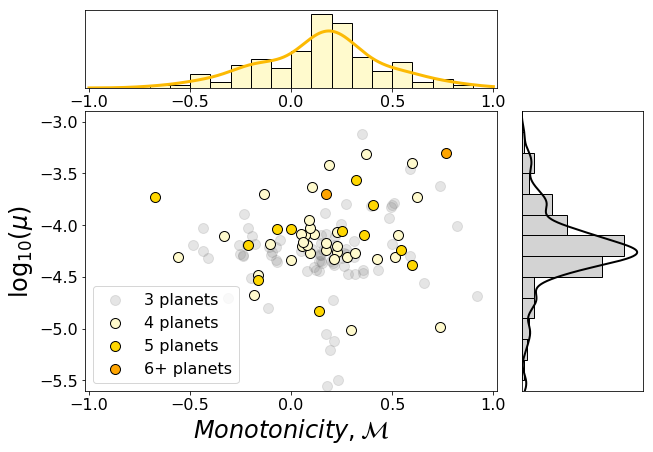

In [23]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(M[N==4], logmu[N==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
ax1.scatter(M[N==5], logmu[N==5], c='gold', edgecolor='k', s=100, label='5 planets')
ax1.scatter(M[N>=6], logmu[N>=6], c='orange', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-1.02,1.02)
ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower left',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# M historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M[N>2])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(M[N>2], bins=np.arange(-1,1,0.1), density=True, color='lemonchiffon', edgecolor='k')
ax1h.plot(x, y, c='#fcba03', lw=3)
ax1h.set_xlim(-1.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-2.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu[N>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu[N>2],bins=np.arange(-5.5,-2.75,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_ylim(-5.6,-2.9)
axsh.set_xticks([])
axsh.tick_params(labelsize=16)


plt.savefig('/Users/research/Desktop/Figures/monotonicity.pdf',bbox_inches='tight')
plt.show()

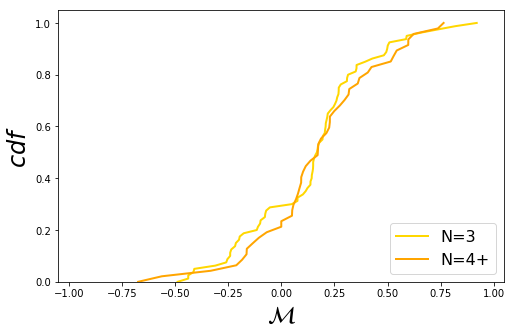

In [24]:
# plot M
plt.figure(figsize=(8,5))
plt.plot(M3, np.linspace(0,1,len(M3)), lw=2, color='gold', label='N=3')
plt.plot(M4, np.linspace(0,1,len(M4)), lw=2, color='orange', label='N=4+')
plt.xlim(-1.05,1.05)
plt.xlabel(r'$\mathcal{M}$', fontsize=24)
plt.ylim(0,1.05)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='lower right', fontsize=16)

In [25]:
fpos = np.sum(M[N>2]>0)/len(M[N>2])
fneg = np.sum(M[N>2]<0)/len(M[N>2])

print('Fraction of systems with M > 0: %.3f' %fpos)
print('Fraction of systems with M < 0: %.3f' %fneg)
print('')

Mmin = M[N>2].min()
print('Minimum M: %.2f' %Mmin)
print('%d systems with M < %.2f' %(np.sum(M[N>2]<=Mmin), Mmin))
print('%d systems with M > +%.2f' %(np.sum(M[N>2]>=-Mmin), -Mmin))

Fraction of systems with M > 0: 0.721
Fraction of systems with M < 0: 0.264

Minimum M: -0.67
1 systems with M < -0.67
5 systems with M > +0.67


# Results for $\mathcal{S}$ and $\mathcal{C}$ 

In [16]:
# 4- and 5-planet systems with second-to-last planet removed
P4 = 2**np.arange(4)
P5 = 2**np.arange(5)

P43 = P4[[0,1,3]]
P54 = P5[[0,1,2,4]]
P53 = P5[[0,1,4]]

pstar43 = np.log(P43[1:]/P43[:-1])/np.log(P43.max()/P43.min())
pstar54 = np.log(P54[1:]/P54[:-1])/np.log(P54.max()/P54.min())
pstar53 = np.log(P53[1:]/P53[:-1])/np.log(P53.max()/P53.min())


C43 = LMC.C(pstar43)
C54 = LMC.C(pstar54)
C53 = LMC.C(pstar53)

print(C43, C54, C53)

[0.33363585] [0.20406347] [0.66319675]


In [17]:
# compare C for 3 and 4+ planet systems
C3 = C[N==3]
C4 = C[N>=4]

C3 = np.sort(np.squeeze(C3))
C4 = np.sort(np.squeeze(C4))

KS_C = np.array(stats.ks_2samp(C3,C4))
AD_C = np.array(stats.anderson_ksamp([C3,C4]))

In [18]:
S2 = S[N==2]
S3 = S[N==3]
S4 = S[N>=4]

S2 = np.sort(S2)
S3 = np.sort(S3)
S4 = np.sort(S4)

KS_S32 = np.array(stats.ks_2samp(S3,S2))
KS_S43 = np.array(stats.ks_2samp(S4,S3))

AD_S32 = np.array(stats.anderson_ksamp([S3,S2]))
AD_S43 = np.array(stats.anderson_ksamp([S4,S3]))

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: p-value floored: true value smaller than 0.001
  del sys.path[0]


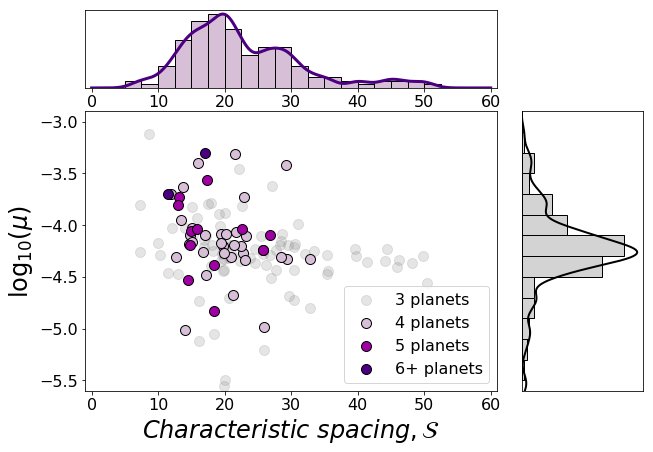

In [19]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# S vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(S[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
ax1.scatter(S[N==5], logmu[N==5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
ax1.scatter(S[N>=6], logmu[N>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-1,61)
ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# S historgram
x = np.linspace(0,60,1000)
y = FFTKDE(kernel='gaussian', bw='ISJ').fit(S[N>2]).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(S[N>2], bins=np.arange(0.0,55.0,2.5), color='thistle', edgecolor='black', density=True)
ax1h.plot(x, y, lw=3, c='indigo')
ax1h.set_yticks([])
ax1h.set_xlim(-1,61)
ax1h.tick_params(labelsize=16)


np.save('/Users/research/Desktop/CKS_echo', np.vstack([x,y]))


# mu historgram
x = np.linspace(-6.0,-2.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu[N>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu[N>2],bins=np.arange(-5.5,-2.75,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_ylim(-5.6,-2.9)
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.savefig('/Users/research/Desktop/Figures/characteristicspacing.pdf',bbox_inches='tight')
plt.show()

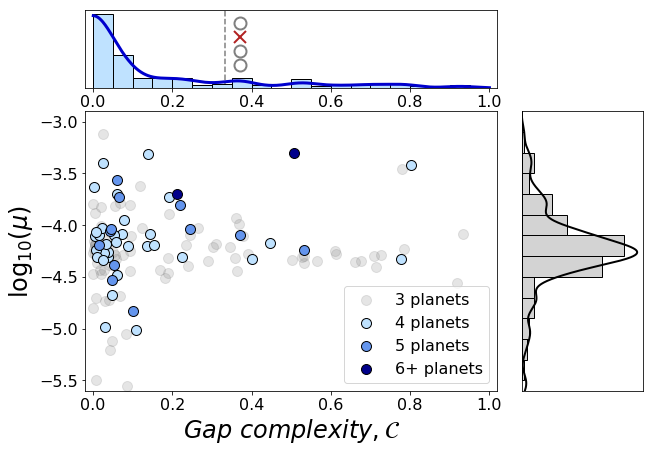

In [20]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# C vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(C[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(C[N==4], logmu[N==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
ax1.scatter(C[N==5], logmu[N==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
ax1.scatter(C[N>=6], logmu[N>=6], c='darkblue', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# C historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-C[N>2],C[N>2]])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(C[N>2], bins=np.arange(0,1,0.05), density=True, color=robinseggblue, edgecolor='k')
ax1h.plot(x[500:],y[500:]*2, c='mediumblue', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])

ax1h.axvline(C43, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.37,0.37,0.37], [2.4,3.9,6.9], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.37], [5.4], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-2.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu[N>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu[N>2],bins=np.arange(-5.5,-2.75,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_ylim(-5.6,-2.9)
axsh.set_xticks([])
axsh.tick_params(labelsize=16)


plt.savefig('/Users/research/Desktop/Figures/gap_complexity.pdf',bbox_inches='tight')
plt.show()

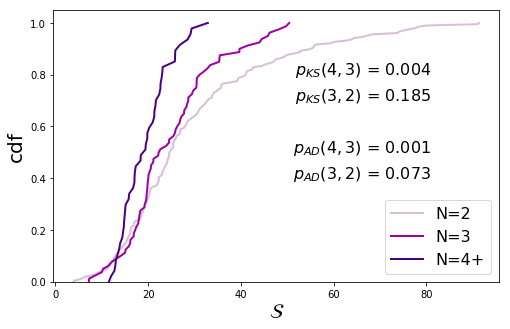

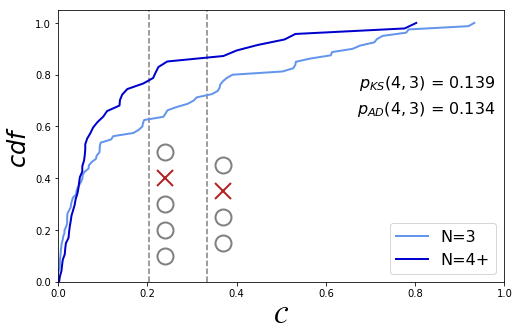

In [21]:
# plot S
plt.figure(figsize=(8,5))
plt.plot(S2,np.linspace(0,1,len(S2)), lw=2, color='thistle', label='N=2')
plt.plot(S3,np.linspace(0,1,len(S3)), lw=2, color=royalpurple,   label='N=3')
plt.plot(S4,np.linspace(0,1,len(S4)), lw=2, color='indigo',   label='N=4+')
plt.legend(loc='lower right', fontsize=16)
plt.xlabel('$\mathcal{S}$', fontsize=20)
plt.ylim(0,1.05)
plt.ylabel('cdf', fontsize=20)
plt.text(81,0.8, r'$p_{KS}(4,3)$ = %.3f' %KS_S43[1], fontsize=16, ha='right')
plt.text(81,0.7, r'$p_{KS}(3,2)$ = %.3f' %KS_S32[1], fontsize=16, ha='right')
plt.text(81,0.5, r'$p_{AD}(4,3)$ = %.3f' %AD_S43[2], fontsize=16, ha='right')
plt.text(81,0.4, r'$p_{AD}(3,2)$ = %.3f' %AD_S32[2], fontsize=16, ha='right')
plt.show()



# plot C
plt.figure(figsize=(8,5))
plt.plot(C3, np.linspace(0,1,len(C3)), lw=2, color='cornflowerblue', label='N=3')
plt.plot(C4, np.linspace(0,1,len(C4)), lw=2, color='mediumblue', label='N=4+')
plt.xlim(0,1)
plt.xlabel(r'$\mathcal{C}$', fontsize=24)
plt.ylim(0,1.05)
plt.ylabel(r'$cdf$', fontsize=24)

plt.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

plt.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)

plt.text(0.98,0.75, r'$p_{KS}(4,3)$ = %.3f' %KS_C[1], fontsize=16, ha='right')
plt.text(0.98,0.65, r'$p_{AD}(4,3)$ = %.3f' %AD_C[2], fontsize=16, ha='right')
plt.legend(loc='lower right', fontsize=16)

plt.show()

# Results for $\mathcal{f}$

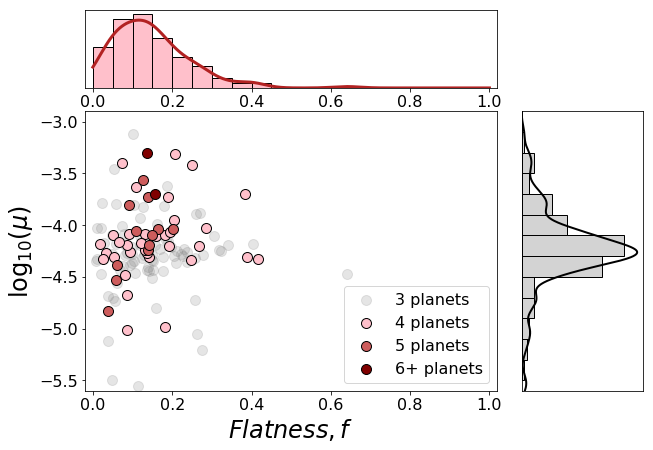

In [26]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# f vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(f[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(f[N==4], logmu[N==4], c='pink', edgecolor='k', s=100, label='4 planets')
ax1.scatter(f[N==5], logmu[N==5], c='indianred', edgecolor='k', s=100, label='5 planets')
ax1.scatter(f[N>=6], logmu[N>=6], c='maroon', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Flatness, f$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# f historgram
x = np.linspace(-0,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(f[N>2])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(f[N>2], bins=np.arange(0,1,0.05), density=True, color='pink', edgecolor='k')
ax1h.plot(x, y, c='firebrick', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-2.5,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu[N>2]).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu[N>2],bins=np.arange(-5.5,-2.75,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_ylim(-5.6,-2.9)
axsh.set_xticks([])
axsh.tick_params(labelsize=16)


plt.savefig('/Users/research/Desktop/Figures/flatness.pdf',bbox_inches='tight')
plt.show()

Text(0.98, 0.65, '$p_{AD}(3,2)$ = 0.015')

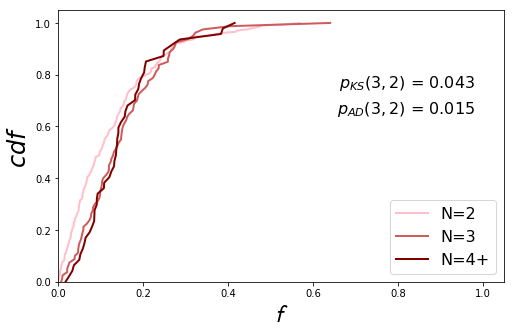

In [27]:
# plot f
f2 = np.sort(f[N==2])
f3 = np.sort(f[N==3])
f4 = np.sort(f[N>=4])

KS_f32 = stats.ks_2samp(f3,f2)
AD_f32 = stats.anderson_ksamp([f3,f2])

plt.figure(figsize=(8,5))
plt.plot(f2, np.linspace(0,1,len(f2)), lw=2, color='pink', label='N=2')
plt.plot(f3, np.linspace(0,1,len(f3)), lw=2, color='indianred', label='N=3')
plt.plot(f4, np.linspace(0,1,len(f4)), lw=2, color='maroon', label='N=4+')
plt.xlim(0,1.05)
plt.xlabel(r'$\mathcal{f}$', fontsize=24)
plt.ylim(0,1.05)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='lower right', fontsize=16)

plt.text(0.98,0.75, r'$p_{KS}(3,2)$ = %.3f' %KS_f32[1], fontsize=16, ha='right')
plt.text(0.98,0.65, r'$p_{AD}(3,2)$ = %.3f' %AD_f32[2], fontsize=16, ha='right')


# Run clustering algorithms

In [29]:
use = (f<1.0)*(N>2)

# these are the variables to run clustering on
mukm = np.log10(mu[use])
Qkm  = Q[use]
Ckm  = C[use]
Skm  = S[use]
fkm  = f[use]
Mkm  = M[use]

mu_N_km = np.log10(mu[use]/N[use])

# track N but don't cluster with it
Nkm  = N[use]

n_systems = np.sum(use)

In [30]:
# build data array
data   = np.vstack([mukm/2.0, Qkm, Ckm, Skm/40, fkm])
labels = ['logmu', 'Q', 'C', 'S', 'f']

n_data = len(data)

data = data.swapaxes(0,1)

In [31]:
def make_similarity_matrix(data, sigma):
    eucDM = DistanceMetric.get_metric('euclidean')
    xij   = eucDM.pairwise(data)
    sij   = np.exp(-xij**2/(2*sigma**2)) - np.eye(len(data))
    
    return sij


# initial similarity matrix
sij = make_similarity_matrix(data, sigma=1.0)

n_nodes = sij.shape[0]

print(n_nodes, 'nodes')

129 nodes


In [32]:
class Graph:
    def __init__(self, similarity_matrix, adjacency_matrix, best_edge_matrix):
        self.S = similarity_matrix
        self.A = adjacency_matrix
        self.B = best_edge_matrix       # should use an upper triangle matrix
        
        self.n_nodes = self.A.shape[0]
        self.index   = np.arange(self.n_nodes)

    
    def pathHelper(self, u, d, visited, path, mpl):
        # mark current node (u) as visited and store it in path
        visited[u] = True
        path.append(u)
        
        # if current node (u) is the destination (d), update best edge strength
        if u == d:
            # get the stength of all edges in the path
            path_edges  = np.ones(len(path)-1)
            for i in range(len(path)-1):
                path_edges[i] = self.S[path[i],path[i+1]]

            # track the strongest edge
            self.best_edge = path_edges.min()

         
        # otherwise, recurse for all adjacent nodes (a)
        elif len(path) <= mpl:
            adj_nodes = self.index[self.A[u]]
            
            # only search down paths that improve over the best edge strength found so far
            for a in adj_nodes:
                if (visited[a] == False):
                    if self.S[u,a] > self.best_edge:
                        self.pathHelper(a, d, visited, path, mpl)
                    else:
                        self.A[u,a] = False
            
        # remove current node from path and mark it as unvisited
        path.pop()
        visited[u] = False
        
        
    def findPaths(self, s, d, mpl):
        # mark all vertices as not visited
        visited = [False]*self.n_nodes
        
        # create a list to store paths
        path = []
        
        # call recursive helper function
        self.pathHelper(s, d, visited, path, mpl)

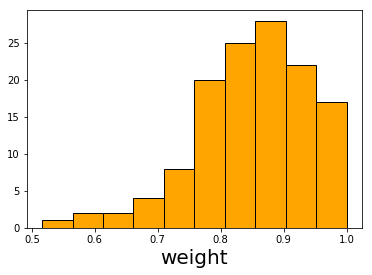

In [33]:
# calculate weights for each point
w = np.zeros(n_nodes)

for i in range(n_nodes):
    w[i] = np.sort(sij[i])[7]
    
w /= w.max()

plt.figure()
plt.hist(w, color='orange', edgecolor='k')
plt.xlabel('weight', fontsize=20)
plt.show()

checking paths (cycle 1, max_path_length = 2)


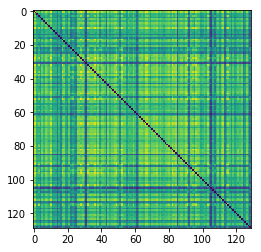


RUNTIME = 0.01

checking paths (cycle 2, max_path_length = 4)


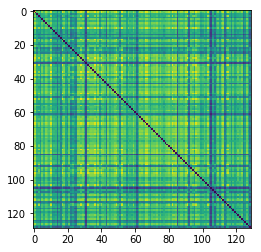


RUNTIME = 0.02

checking paths (cycle 3, max_path_length = 8)


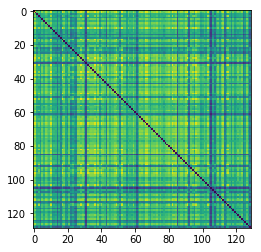


RUNTIME = 0.03

checking paths (cycle 4, max_path_length = 16)


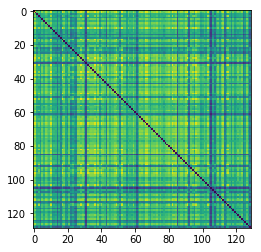


RUNTIME = 0.03

checking paths (cycle 5, max_path_length = 32)


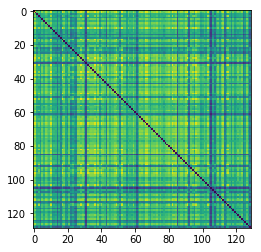


RUNTIME = 0.04

checking paths (cycle 6, max_path_length = 64)


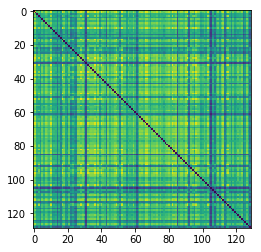


RUNTIME = 0.05

checking paths (cycle 7, max_path_length = 128)


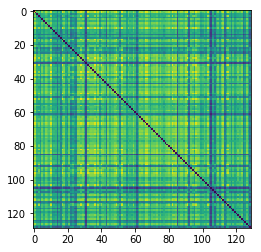


RUNTIME = 0.06


TOTAL RUNTIME = 0.06



In [34]:
# set maximum path length to search
max_path_length = 2


# initialize the graph
new_sij = np.outer(w,w)*sij
new_aij = new_sij > 0.0
new_bij = np.triu(new_sij)

g = Graph(new_sij, new_aij, new_bij)


# start timer
start_time = default_timer()


# now iteratively find paths through the graph
cycle = 1
while max_path_length**cycle < n_nodes:
    print('checking paths (cycle %d, max_path_length = %d)' %(cycle, max_path_length**cycle))
    
    # use DFS to find paths through the graph
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            g.best_edge = g.B[i,j]              # track strongest edge
            g.A *= (g.S >= g.best_edge)         # zero out any edges weaker than this (in adjacency matrix)
            g.findPaths(i, j, max_path_length)  # search for paths through the graph
            g.A = new_aij.copy()                # reset the adjacency matrix
            g.B[i,j] = g.best_edge.copy()       # store the best edge strength found
    
    # update graph
    new_sij = (g.B + g.B.T)
    new_aij = new_sij > 0.0
    new_bij = np.triu(new_sij.copy())
    
    g = Graph(new_sij, new_aij, new_bij)
    
    
    # plot the matrix
    plt.figure()
    plt.imshow(new_sij)
    plt.show()
    
    
    # run clustering on this new matrix
    sc = SpectralClustering(n_clusters=3, affinity='precomputed')
    scfit = sc.fit_predict(new_sij)
    
    # increment cycle counter
    cycle += 1
    
    print('\nRUNTIME = %.2f\n' %((default_timer()-start_time)/60))

    

end_time = default_timer()

print('\nTOTAL RUNTIME = %.2f\n' %((end_time-start_time)/60))


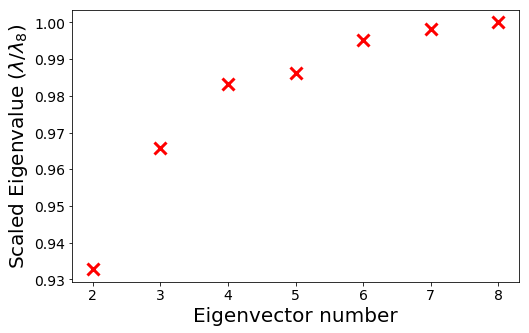

In [35]:
# construct graph laplacian
A = new_sij.copy()
W = A * (1 - np.eye(n_nodes))
D = np.diag(W.sum(axis=1))
L = D - W

# normalize (symmetric method)
D12   = np.linalg.inv(np.sqrt(D))
Lnorm = np.dot(np.dot(D12,L),D12)

# get eigenvectors & eigenvalues
lam, v = np.linalg.eig(Lnorm)

order = np.argsort(lam)
lam = lam[order]
v   = v[:,order]

plt.figure(figsize=(8,5))
plt.plot(2+np.arange(7), lam[1:8]/np.max(lam[1:8]), 'x', c='red', mew=3, ms=12)
plt.xlabel(r'Eigenvector number', fontsize=20)
plt.ylabel(r'Scaled Eigenvalue ($\lambda/\lambda_8$)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('/Users/research/Desktop/Figures/eigengaps.pdf', bbox_inches='tight')
plt.show()

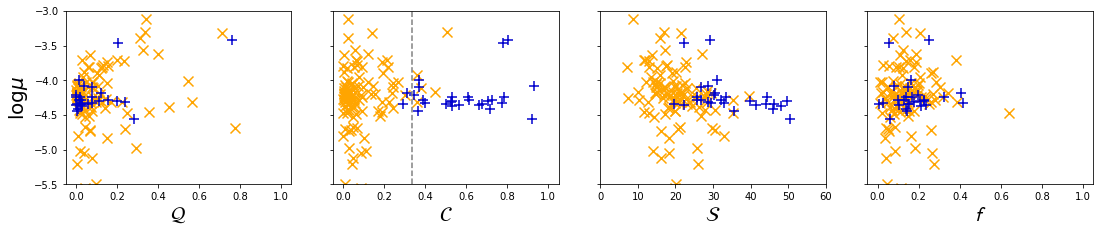

In [36]:
n_clusters = 2

# robust path-based clustering
pb = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
pbfit = pb.fit_predict(new_sij)


# compare Q, C, S, f vs logmu
colors = ['orange', 'mediumblue', 'firebrick', 'navy', 'purple', 'red']
markers = ['x', '+', '*', '^', 'd', 's']
msize   = [100, 100, 150, 100, 100, 100]
facecolors = ['orange', 'mediumblue', 'none', 'none', 'none', 'none']


fig, axes = plt.subplots(1,4, figsize=(15,3))
plt.tight_layout()

ax = axes[0]
for i in range(n_clusters):
    ax.scatter(Qkm[pbfit==i], mukm[pbfit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlim(-0.05,1.05)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=20)
ax.set_ylabel(r'$\log\mu$', fontsize=20)
ax.set_ylim(-5.5,-3.0)

ax = axes[1]
for i in range(n_clusters):
    ax.scatter(Ckm[pbfit==i], mukm[pbfit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.axvline(C43, linestyle='--', color='grey')
ax.set_xlabel(r'$\mathcal{C}$', fontsize=20)
ax.set_xlim(-0.05,1.05)
ax.set_ylabel('')
ax.set_ylim(-5.5,-3.0)
ax.set_yticklabels([])

ax = axes[2]
for i in range(n_clusters):
    ax.scatter(Skm[pbfit==i], mukm[pbfit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{S}$', fontsize=20)
ax.set_xlim(0,60)
ax.set_ylabel('')
ax.set_ylim(-5.5,-3.0)
ax.set_yticklabels([])

ax = axes[3]
for i in range(n_clusters):
    ax.scatter(fkm[pbfit==i], mukm[pbfit==i], s=msize[i], color=colors[i], marker=markers[i], \
               facecolors=facecolors[i])
ax.set_xlabel(r'$\mathcal{f}$', fontsize=20)
ax.set_xlim(-0.05,1.05)
ax.set_ylabel('')
ax.set_ylim(-5.5,-3.0)
ax.set_yticklabels([])

plt.savefig('/Users/research/Desktop/Figures/clustered_X_vs_logmu.pdf', bbox_inches='tight')
plt.show()

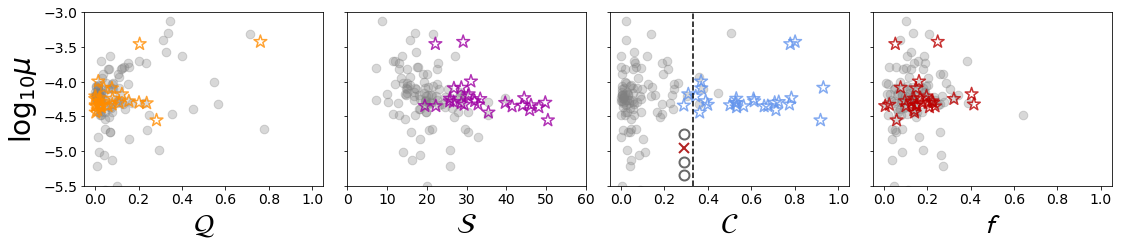

In [37]:
fig, axes = plt.subplots(1,4, figsize=(15,3))
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

ax = axes[0]
ax.scatter(Qkm[pbfit==0], mukm[pbfit==0], s=75, color='grey', marker='o', alpha=0.3)
ax.scatter(Qkm[pbfit==1], mukm[pbfit==1], s=180, color='darkorange', facecolor='none', marker='*', lw=1.5, alpha=0.8)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=28)
ax.set_ylabel(r'$\log_{10}\mu$', fontsize=28)
ax.set_ylim(-5.5,-3.0)
ax.tick_params(labelsize=14)

ax = axes[1]
ax.scatter(Skm[pbfit==0], mukm[pbfit==0], s=75, color='grey', marker='o', alpha=0.3)
ax.scatter(Skm[pbfit==1], mukm[pbfit==1], s=180, color=royalpurple, facecolor='none', marker='*', lw=1.5, alpha=0.8)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=28)
ax.set_xlim(0,60)
ax.set_xticks(np.arange(0,70,10))
ax.set_ylabel('')
ax.set_ylim(-5.5,-3.0)
ax.set_yticklabels([])
ax.tick_params(labelsize=14)

ax = axes[2]
ax.scatter(Ckm[pbfit==0], mukm[pbfit==0], s=75, color='grey', marker='o', alpha=0.3)
ax.scatter(Ckm[pbfit==1], mukm[pbfit==1], s=180, color='cornflowerblue', facecolor='none', marker='*', lw=1.5, alpha=0.8)
ax.axvline(C43, linestyle='--', color='k')
ax.set_xlabel(r'$\mathcal{C}$', fontsize=28)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_ylabel('')
ax.set_ylim(-5.5,-3.0)
ax.set_yticklabels([])
ax.plot([0.29,0.29,0.29], [-5.35,-5.15,-4.75], 'o', c='dimgrey', ms=10, fillstyle='none', mew=2)
ax.plot([0.29], [-4.95], 'x', c='firebrick', ms=10, mew=2)
ax.tick_params(labelsize=14)

ax = axes[3]
ax.scatter(fkm[pbfit==0], mukm[pbfit==0], s=75, color='grey', marker='o', alpha=0.3)
ax.scatter(fkm[pbfit==1], mukm[pbfit==1], s=180, color='#bb0000', facecolor='none', marker='*', lw=1.5, alpha=0.8)
ax.set_xlabel(r'$\mathcal{f}$', fontsize=28)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_ylabel('')
ax.set_ylim(-5.5,-3.0)
ax.set_yticklabels([])
ax.tick_params(labelsize=14)

plt.savefig('/Users/research/Desktop/Figures/clustered_X_vs_logmu.pdf', bbox_inches='tight')
plt.show()

# Downsampling to make synthetic 3-planet catalogue

In [41]:
def P_to_a(P, Mstar):
    '''
    P: orbital periods [days]
    Mstar: stellar mass [solar masses]
    '''
    Pearth = 365.24    # [days]
    aearth = 215.05    # [solar radii]
    
    a = aearth * ((P/Pearth)**2 *(1/Mstar))**(1/3)
    
    return a

def transit_prob(a, Rstar):
    '''
    a: semi-major axis [solar radii]
    Rstar: stellar radius [solar radii]
    '''
    return Rstar/a

In [48]:
sys3 = []
sys4 = []

# pull 3- and 4- planet systems
for i, s in enumerate(systems):
    if s.N == 3:
        sys3.append(s)
    elif s.N >= 4:
        sys4.append(s)
        

synthetic3 = []

while len(synthetic3) < len(sys3):
    draw_sys4 = np.random.choice(sys4)
    
    a  = P_to_a(draw_sys4.periods, draw_sys4.Mstar)
    tp = transit_prob(a, draw_sys4.Rstar)
    
    i = 0
    loop = True
    while loop:
        i += 1
        
        rn   = np.random.uniform(size=len(tp))
        keep = tp > rn
    
        if np.sum(keep) == 3:
            s = System()
            
            # downsample to create synthetic system
            s.sysid = len(synthetic3)
            s.Mstar = draw_sys4.Mstar
            s.Rstar = draw_sys4.Rstar
            
            s.rprs    = draw_sys4.rprs[keep]
            s.masses  = draw_sys4.masses[keep]
            s.periods = draw_sys4.periods[keep]
            
            s.dur      = draw_sys4.dur[keep]
            s.dur_err = draw_sys4.dur_err[keep]
            
            # calculate complexity measures (N, mu, Q, M, S, C, f)
            s.N  = len(s.masses)
            s.mu = archinfo.mu(s.masses, s.Mstar)
            s.Q  = archinfo.Q(s.masses)
            s.M  = archinfo.M(s.periods, s.masses)
            s.S  = archinfo.S(s.periods, s.masses, s.Mstar)
            s.C  = archinfo.C(s.periods)
            s.f  = archinfo.f(s.periods, s.Mstar/s.Rstar**3, s.rprs, s.dur, s.dur_err)
      
            # add to list of synthetic 3-planet systems
            synthetic3.append(s)
            loop = False
            
        if i > len(sys4):
            loop = False

In [54]:
ds_logmu = []
ds_Q = []
ds_M = []
ds_S = []
ds_C = []
ds_f = []

for i, s in enumerate(synthetic3):
    ds_logmu.append(np.log10(s.mu))
    ds_Q.append(s.Q)
    ds_M.append(s.M)
    ds_S.append(s.S)
    ds_C.append(s.C)
    ds_f.append(s.f)
    
    
ds_logmu = np.array(ds_logmu)
ds_Q = np.array(ds_Q)
ds_M = np.array(ds_M)
ds_S = np.array(ds_S)
ds_C = np.squeeze(np.array(ds_C))
ds_f = np.array(ds_f)

In [56]:
use3 = N == 3

pKS_dsQ = np.array(stats.ks_2samp(Q[use3],ds_Q))[1]
pKS_dsC = np.array(stats.ks_2samp(C[use3],ds_C))[1]
pKS_dsS = np.array(stats.ks_2samp(S[use3],ds_S))[1]
pKS_dsf = np.array(stats.ks_2samp(f[use3],ds_f))[1]

pAD_dsQ = stats.anderson_ksamp([Q[use3],ds_Q])[2]
pAD_dsC = stats.anderson_ksamp([C[use3],ds_C])[2]
pAD_dsS = stats.anderson_ksamp([S[use3],ds_S])[2]
pAD_dsf = stats.anderson_ksamp([f[use3],ds_f])[2]

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: p-value floored: true value smaller than 0.001
  # This is added back by InteractiveShellApp.init_path()


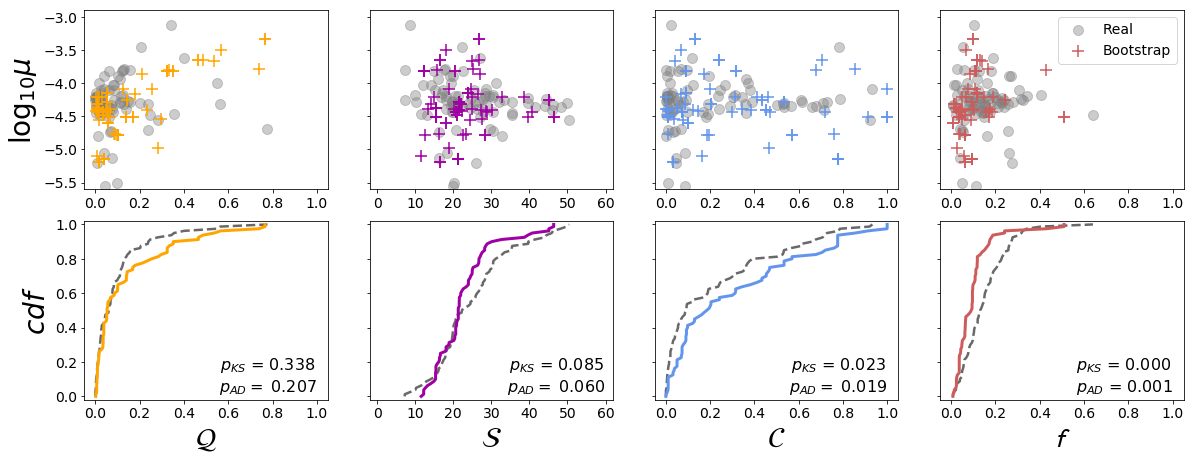

In [57]:
fig, axes = plt.subplots(2,4, figsize=(16,6))

plt.tight_layout()

ax = axes[0,0]
ax.scatter(Q[use3], logmu[use3], s=100, color='grey', alpha=0.4, label='Real')
ax.scatter(ds_Q, ds_logmu, s=150, color='orange', marker='+', label='Bootstrap')
ax.set_ylabel(r'$\log_{10}\mu$', fontsize=28)
ax.set_ylim(-5.6,-2.9)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,.2))
ax.tick_params(labelsize=14)

ax = axes[0,1]
ax.scatter(S[use3], logmu[use3], s=100, color='grey', alpha=0.4, label='Real')
ax.scatter(ds_S, ds_logmu, s=150, color=royalpurple, marker='+', label='Bootstrap')
ax.set_ylim(-5.6,-2.9)
ax.set_yticklabels([])
ax.set_xlim(-2,62)
ax.set_xticks(np.arange(0,70,10))
ax.tick_params(labelsize=14)

ax = axes[0,2]
ax.scatter(C[use3], logmu[use3], s=100, color='grey', alpha=0.4, label='Real')
ax.scatter(ds_C, ds_logmu, s=150, color='cornflowerblue', marker='+', label='Bootstrap')
ax.set_ylim(-5.6,-2.9)
ax.set_yticklabels([])
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,.2))
ax.tick_params(labelsize=14)

ax = axes[0,3]
ax.scatter(f[use3], logmu[use3], s=100, color='grey', alpha=0.4, label='Real')
ax.scatter(ds_f, ds_logmu, s=150, color='indianred', marker='+', label='Bootstrap')
ax.set_ylim(-5.6,-2.9)
ax.set_yticklabels([])
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,.2))
ax.tick_params(labelsize=14)
ax.legend(loc='upper right', fontsize=14)


ax = axes[1,0]
ax.plot(np.sort(Q[N==3]), np.linspace(0,1,len(Q[N==3])), lw=2.5, ls='--', c='dimgrey', label='Real')
ax.plot(np.sort(ds_Q), np.linspace(0,1,len(ds_Q)), lw=3, c='orange', label='Bootstrap')
ax.set_ylabel(r'$cdf$', fontsize=28)
ax.set_ylim(-0.02,1.02)
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,.2))
ax.text(1.0, 0.0, '$p_{KS}$ = %.3f \n$p_{AD} =$ %.3f' %(pKS_dsQ, pAD_dsQ), fontsize=16, ha='right', va='bottom')
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=28)

ax = axes[1,1]
ax.plot(np.sort(S[N==3]), np.linspace(0,1,len(S[N==3])), lw=2.5, ls='--', c='dimgrey', label='Real')
ax.plot(np.sort(ds_S), np.linspace(0,1,len(ds_S)), lw=3, c=royalpurple, label='Bootstrap')
ax.set_ylim(-0.02,1.02)
ax.set_yticklabels([])
ax.set_xlim(-2,62)
ax.set_xticks(np.arange(0,70,10))
ax.text(60, 0.0, '$p_{KS}$ = %.3f \n$p_{AD} =$ %.3f' %(pKS_dsS, pAD_dsS), fontsize=16, ha='right', va='bottom')
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=28)

ax = axes[1,2]
ax.plot(np.sort(C[N==3]), np.linspace(0,1,len(C[N==3])), lw=2.5, ls='--', c='dimgrey', label='Real')
ax.plot(np.sort(ds_C), np.linspace(0,1,len(ds_C)), lw=3, c='cornflowerblue', label='Bootstrap')
ax.set_ylim(-0.02,1.02)
ax.set_yticklabels([])
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,.2))
ax.text(1.0, 0.0, '$p_{KS}$ = %.3f \n$p_{AD} =$ %.3f' %(pKS_dsC, pAD_dsC), fontsize=16, ha='right', va='bottom')
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=28)

ax = axes[1,3]
ax.plot(np.sort(f[N==3]), np.linspace(0,1,len(f[N==3])), lw=2.5, ls='--', c='dimgrey', label='Real')
ax.plot(np.sort(ds_f), np.linspace(0,1,len(ds_f)), lw=3, c='indianred', label='Bootstrap')
ax.set_ylim(-0.02,1.02)
ax.set_yticklabels([])
ax.set_xlim(-0.05,1.05)
ax.set_xticks(np.arange(0,1.2,.2))
ax.text(1.0, 0.0, '$p_{KS}$ = %.3f \n$p_{AD}$ = %.3f' %(pKS_dsf, pAD_dsf), fontsize=16, ha='right', va='bottom')
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\mathcal{f}$', fontsize=28)

plt.savefig('/Users/research/Desktop/Figures/downsampled3s.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Check distance correlation

In [62]:
data = [logmu[N>2], Q[N>2], M[N>2], S[N>2], C[N>2], f[N>2]]
name = ['logmu', 'Q', 'M', 'S', 'C', 'f']


for i in range(6):
    for j in range(i+1,6):
        print(name[i], name[j], '\tdcor=', np.round(dcor.distance_correlation(data[i], data[j]), 2))


logmu Q 	dcor= 0.38
logmu M 	dcor= 0.27
logmu S 	dcor= 0.32
logmu C 	dcor= 0.19
logmu f 	dcor= 0.15
Q M 	dcor= 0.48
Q S 	dcor= 0.16
Q C 	dcor= 0.11
Q f 	dcor= 0.14
M S 	dcor= 0.15
M C 	dcor= 0.17
M f 	dcor= 0.13
S C 	dcor= 0.52
S f 	dcor= 0.36
C f 	dcor= 0.16


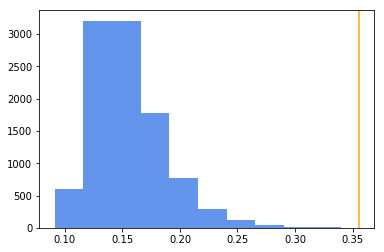

In [63]:
nboot = 10000

bootstrap_dcor = np.zeros(nboot)
f_shuffle = f[N>2].copy()
    
for i in range(nboot):
    random.shuffle(f_shuffle)
    bootstrap_dcor[i] = dcor.distance_correlation(S[N>2], f_shuffle)
    
    
plt.figure()
plt.hist(bootstrap_dcor, color='cornflowerblue')
plt.axvline(dcor.distance_correlation(S[N>2], f[N>2]), color='orange')
plt.show()

print(np.sum(bootstrap_dcor > dcor.distance_correlation(S[N>2], f[N>2])))

# Convert radius to mass following Wolfgang, Rogers, & Ford (2015)

In [ ]:
# CONVERT RADIUS TO MASS
def radius_to_mass(R):
    '''
    converts radius (R_earth) to mass (M_earth) with a probabilistic M-R relation
    '''
    L0 = len(R)
    
    # apply the M-R relation of Wolfgang, Rogers, & Ford (2015) -- small/medium planets
    C = np.zeros(L0)
    y = np.zeros(L0)
    
    C[R<=1.6] = 1.4
    y[R<=1.6] = 2.3
        
    C[(R<=4.0)*(R>1.6)] = 2.7
    y[(R<=4.0)*(R>1.6)] = 1.3
    
    C[(R<=8.0)*(R>4.0)] = 1.6
    y[(R<=8.0)*(R>4.0)] = 1.8
    
    M = C*np.power(R,y)
    
    # scale mass of large planets linear with radius based on Saturn mass [BAD METHOD!!!]
    M[(R>8.0)] = 95.1608*R[R>8.0]/9.1402
    
    return M

In [ ]:
# do the inner solar system

mp_iss = np.array([0.05527, 0.815, 1.0, 0.1074])
rp_iis = np.array([0.383, 0.95, 1.0, 0.532])
P_iss  = np.array([87.96, 224.7, 365.24, 686.9])

C_iss = LMC.C(P_iss[1:]/P_iss[:-1])
Q_iss = LMC.D(mp_iss/np.sum(mp_iss))
u_iss = np.sum(mp_iss)/MSME
M_iss = stats.spearmanr(P_iss, mp_iss)[0]*Q_iss**0.25


print('log(mu) = %.2f' %np.log10(u_iss))
print('Q = %.2f' %Q_iss)
print('M = %.2f' %M_iss)
print('C = %.2f' %C_iss)